# COGS 108 - Final Project (change this to your project's title)

# Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [  ] YES - make available
* [  ] NO - keep private

# Names

- Tony Bai
- Ryan Regala
- Jiwon Kim
- Colin Isidro
- Rambharath Saravanan

# Abstract

Please write one to four paragraphs that describe a very brief overview of why you did this, how you did, and the major findings and conclusions.

# Research Question

Based on an anime's genre(s), number of episodes, studio(s) that animated it, platform(s) it is being streamed on, and its source material (manga, light novel, visual novel, etc.), can we predict its score on MyAnimeList, a platform that gives an anime a score by aggregating scores given by its users from 1-10

## Background and Prior Work

For our project, we want to look at multiple different qualities in anime and see if we can use that to predict the score of an anime on MyAnimeList. From our research, we know that MyAnimeList has the biggest data on anime with having the least amount of missing data. The same source mentions that there were no strict web scraping policies as of early 2024, but further research suggests the scraping the website wouldn't be allowed, yet we would be allowed to get data from their API that has similar data if we wanted. We also know a lot about how MyAnimeList calculates its weighted average anime scores from the previous projects. <a name="ref-2"></a>[<sup>2</sup>](#ref-2) On top of that, we also found out that using a non-linear regression model would be more accurate than a linear one since their scores are also calculated on a non-linear formula.<a name="ref-1"></a>[<sup>1</sup>](#ref-1)

Another project suggests that multimodal data decreases the error in prediction models for MyAnimeList scores. <a name="ref-2"></a>[<sup>2</sup>](#ref-2) So, our project could put that into consideration as well as the genre, episodes, liscensing platforms, and source material previously mentioned in the research question. A project also puts forth a good practice of checking the collinearity of the variables we are checking for.<a name="ref-1"></a>[<sup>1</sup>](#ref-1)

## Metis Project 2: Prediction Model on Anime Rating Score
In this project, the author tries to make a prediction model based on MyAnimeList scores. They first scraped the data from that website, created a collinearity heat map to remove highly collinear features. They then used multiple linear regression models and finalized with using the one that had the least amount of error (Polynomial). They found that anime based off manga, added as Favorite on MAL, and produced by Production I.G. showed a correlation with popular anime rating scores. Though, they also specified that MAL specifies that their anime scores are calculated on a non-linear formula while this prediction model was more linear. 

1. <a name="ref1"></a> [^](#ref-1)Ting, K. S. (2021, December 16). Metis Project 2: Prediction Model on Anime Rating Score. Medium. https://medium.com/@sitingkoh1808/metis-project-2-prediction-model-on-anime-rating-score-65d9b5e3a6

## Anime Popularity Prediction Before Huge Investments: a Multimodal Approach Using Deep Learning
This project aims to predict the popularity of an anime (based off of MAL scores) using multimodal text-image data. They used a 3 input deep neural network with the input of synopsis, main character descriptions, and main character portraits. They found that their model best worked with the multimodal data in their prediction of MAL ratings. Though, they say that the model could be improved with more RAM allocated to the analysis, allowing images to be encoded into more tokens.

2. <a name="ref2"></a> [^](#ref-2) Armenta-Segura, J., & Sidorov, G. (2024). Anime Popularity Prediction Before Huge Investments: a Multimodal Approach Using Deep Learning. arXiv preprint arXiv:2406.16961.

# Hypothesis


Our hypothesis is that the more popular genres, more well known animation studios, and more well known streaming platforms will be strongly positively correlated with a higher score compared to less popular genres, animation studios, and streaming platforms; an anime's episode count will be positively correlated with its score; and the source material of an anime will have no correlation with its score. 

More popular genres, well known animation studios and streaming platforms, by virtue of being more popular well known, will have higher scores because they already have a fanbase that will inevitably be biased and think more highly of them. We think an anime's episode count will be positively correlated with its score because most of the highest rated animes on MyAnimeList have more episodes than the average episode count nowadays, which is 12. We think an anime's source material will have no correlation with its score because we think all the source materials have similar amounts of good and bad adaptations.

# Data

## Data overview

- Dataset #1
  - Dataset Name: Anime Dataset 2023
  - Link to the dataset: https://www.kaggle.com/datasets/dbdmobile/myanimelist-dataset/data
  - Number of observations: 24905
  - Number of variables: 24

In Anime Dataset 2023, we have data on animes as recent as September 2022 (Summer 2022 season) and as far back as 1900s. There are a total of 24 columns in this dataset but the ones we care about are name, score, genres, episodes, studio, source, and licensors. 

Name contains the English pronouciation of names of every anime, score contains the aggregated score from each user that rated the animes, genres contains the genres for each anime (often multiple genres for each anime), studio contains the name of the animating studio(s) that did the work of adapting the show into anime (e.g. Bones, Madhouse, Toei Animations, etc.), source contains the source material that each anime was adapted from (anime original, manga, light novel, etc.), and licensors contains the platform(s) the anime was streamed on (e.g. Crunchyroll, Funimation, Bandai Entertainment, etc.). 

The first step of cleaning would be filter out all the animes in the dataset that doesn't have "TV" in the Type column since we want to only focus on animes that are aired as TV shows, having other types within our model (movies, OVAs ONAs, etc.) could skew our results since those are a different medium. In addition, there are a lot of missing data (marked as UNKNOWN) in the dataset which we can fill in ourselves using MyAnimeList's API, and if there are any UNKNOWN data after that we can remove because those data doesn't exist, the most common explanations would be either the anime is still airing (unknown episode count) or no one has ever scored the anime (unknown aggregate score).

## Anime Dataset 2023

In [3]:
import pandas as pd
import requests
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def scoreScraping(subset : pd.DataFrame):
    '''For reading in MyAnimeList scores using its API'''
    url = "https://api.myanimelist.net/v2/anime/"
    clientHeader = {'X-MAL-CLIENT-ID':'be63c0a5e8517ce10df18a744cbf9045'}
    for i in range(subset.shape[0]):
        row = subset.iloc[i]

        if row.get('Score') == 'UNKNOWN': # if score is missing
            anime_id = row.get('anime_id')
            index = row.name

            response = requests.get(url + str(anime_id) + '?fields=mean', headers=clientHeader)
            if response.status_code == 200: # if response is returned successfully
                json = response.json()
                if 'mean' in json: # if a score was read in
                    subset.loc[index, 'Score'] = json['mean']

    return subset

In [ ]:
def aniListScraping(dataset : pd.DataFrame):
    '''For reading in genres, episode count, studios, streaming website, and source off AniList API'''
    url = 'https://graphql.anilist.co'
    query = '''
    query ($idMal: Int!) { # Define which variables will be used in the query (id)
        Media (idMal: $idMal, type: ANIME) { # Insert our variables into the query arguments (id) (type: ANIME is hard-coded in the query)
            genres
            episodes
            studios{
                nodes{
                    name
                    isAnimationStudio
                }
            }   
            streamingEpisodes{
                site
            }
            source
        }
    }
    '''
    # get the subset of missing data and get the index of subset
    subset = dataset[(dataset.get('Genres') == 'UNKNOWN') | (dataset.get('Episodes') == 'UNKNOWN') | (dataset.get('Studios') == 'UNKNOWN') 
                     | (dataset.get('Licensors') == 'UNKNOWN') | (dataset.get('Source') == 'Unknown')]
    indicies = subset.index

    for index in indicies:
        entry = dataset.loc[index]
        variables = {'idMal': entry.get('anime_id').item()}
        response = requests.post(url, json={'query': query, 'variables': variables})

        if response.status_code == 429: # if ratelimit was reached
            time.sleep(61)
            response = requests.post(url, json={'query': query, 'variables': variables})

        if response.status_code == 200: # if reponse is returned successfully
            data = response.json()['data']['Media']

            if entry.get('Genres') == 'UNKNOWN' and 'genres' in data:
                dataset.loc[index, 'Genres'] = ','.join(data['genres'])
            if entry.get('Episodes') == 'UNKNOWN' and 'episodes' in data:
                dataset.loc[index, 'Episodes'] = data['episodes']
            if entry.get('Studios') == 'UNKNOWN' and 'studios' in data:
                studios = data['studios']['nodes']
                cellEntry = []
                for studio in studios:
                    if studio['isAnimationStudio']:
                        cellEntry.append(studio['name'])
                dataset.loc[index, 'Studios'] = ','.join(cellEntry)
            if entry.get('Licensors') == 'UNKNOWN' and 'streamingEpisodes' in data:
                if len(data['streamingEpisodes']) != 0:
                    dataset.loc[index, 'Licensors'] = data['streamingEpisodes'][0]['site']
            if entry.get('Source') == 'Unknown' and 'source' in data:
                dataset.loc[index, 'Source'] = data['source']


In [ ]:
# import initial dataset
dataset = pd.read_csv('anime-dataset-2023.csv')
dataset = dataset[dataset.get('Type') == 'TV'].get(['anime_id', 'Name', 'Score', 'Genres', 'Episodes', 'Studios', 'Licensors', 'Source'])

Because MyAnimeList's API forces a cooldown if it is accessed too many times in a short amount of time, we are forced to wait 5 minutes between each chunk of API requests

In [ ]:
ranges = np.arange(500, 7597, 500)
ranges = np.append(ranges, 7597)

print(f'Starting chunk 0')
dataset[ranges[0]+1:ranges[0+1]] = scoreScraping(dataset[ranges[0]+1:ranges[0+1]])
print(f'Finished chunk 0')
for i in range(len(ranges) - 1):
    print(f'Starting chunk {ranges[i]}')
    dataset[ranges[i]+1:ranges[i+1]] = scoreScraping(dataset[ranges[i]+1:ranges[i+1]])
    print(f'Finished chunk {ranges[i]}')
    print('Starting 5 min cooldown')
    time.sleep(300)


Because this one single cell took more than 1 hour, I will save the edited dataset as 'edited-anime-dataset.csv' so we won't have to do that ever again

In [ ]:
dataset.to_csv('edited-anime-dataset.csv', index=False)

In [ ]:
# import edited dataset
editedset = pd.read_csv('edited-anime-dataset.csv')
# check how many unknown scores we have now
editedset[editedset.get('Score') == 'UNKNOWN'].shape

(2807, 8)

Although we have run our function to call the MAL API to try and get the score, many of them still has that cell empty because no one has ever scored them. Since an anime's score is crucial in our model, we will remove the ones that have it missing because they are unhelpful

In [ ]:
editedset = editedset[dataset.get('Score') != 'UNKNOWN']
editedset[editedset.get('Score') == 'UNKNOWN'].shape

(0, 8)

We will now use AniList's API to get any missing data in Genres, Episodes, Studios, Licensors, and Source since AniList's API is more sophisticated and allows us to get Licensors, a piece of information that we cannot get off of MyAnimeList's API

In [ ]:
aniListScraping(editedset)

This one function call also took more than an hour because AniList's API has a rate limit of 30 calls per minute, and if it is reached we get put on a 1 minute cooldown, so for timesaving we will also save this final dataset. After this we are free from getting information from APIs

In [ ]:
editedset.to_csv('final-anime-dataset.csv', index=False)

In [ ]:
finalset = pd.read_csv('final-anime-dataset.csv')

In [ ]:
print(finalset[(finalset.get('Genres') == 'UNKNOWN') | (finalset.get('Episodes') == 'UNKNOWN') | (finalset.get('Studios') == 'UNKNOWN') | 
                     (finalset.get('Licensors') == 'UNKNOWN')].shape)
print(finalset[(finalset.get('Licensors') == 'UNKNOWN')].shape)
finalset[(finalset.get('Licensors') == 'UNKNOWN')].head()

(1732, 8)
(1732, 8)


,anime_id,Name,Score,Genres,Episodes,Studios,Licensors,Source
6,17,Hungry Heart: Wild Striker,7.55,"Comedy, Slice of Life, Sports",52.0,Nippon Animation,UNKNOWN,Manga
12,23,Ring ni Kakero 1,6.39,"Action, Sports",12.0,Toei Animation,UNKNOWN,Manga
33,62,D.C.: Da Capo,6.72,"Drama, Romance",26.0,"feel., Zexcs",UNKNOWN,Visual novel
64,102,Aishiteruze Baby★★,7.44,"Comedy, Drama, Romance",26.0,TMS Entertainment,UNKNOWN,Manga
65,103,Akazukin Chacha,7.49,"Adventure, Comedy, Fantasy, Romance",74.0,Gallop,UNKNOWN,Manga


after scraping information off AniList's API we still have a lot of unknown information, all of them having at least the Licensors column missing, most likely because they were aired on TV before streaming platforms like Crunchyroll were a thing so these animes aren't on any streaming platforms. We are free to remove these animes since that information simply doesn't exist

In [ ]:
finalset = finalset[(finalset.get('Licensors') != 'UNKNOWN')]
finalset.shape

(3058, 8)

In [ ]:
print(finalset.isnull().sum(axis=0))

anime_id      0
Name          0
Score         0
Genres        4
Episodes      7
Studios      16
Licensors     0
Source        0
dtype: int64


Looks like we also got some nulls from the function call

In [ ]:
finalset[finalset.get('Genres').isnull()]

,anime_id,Name,Score,Genres,Episodes,Studios,Licensors,Source
1968,8753,Ultraman Kids: Haha wo Tazunete 3000-man Kounen,6.09,NaN,26.0,NaN,Mill Creek Entertainment,Other
2399,15547,Cross Fight B-Daman eS,6.45,NaN,52.0,SynergySP,ADK Emotions NY,Unknown
2685,21835,Majin Bone,6.62,NaN,52.0,Toei Animation,Crunchyroll,Game
2731,22735,Oreca Battle,5.86,NaN,51.0,"Xebec, OLM",Crunchyroll,Game


searching for these animes on AniList, they simply have no genres listed, one reason as to why might be because they are all children's shows. Since we want genres in our analysis, we will drop these animes because they are unhelpful for our prediction

In [ ]:
finalset[finalset.get('Episodes').isnull()]

,anime_id,Name,Score,Genres,Episodes,Studios,Licensors,Source
10,21,One Piece,8.69,"Action, Adventure, Fantasy",NaN,Toei Animation,"Funimation, 4Kids Entertainment",Manga
159,235,Detective Conan,8.17,"Adventure, Comedy, Mystery",NaN,TMS Entertainment,"Funimation, Crunchyroll",Manga
522,966,Crayon Shin-chan,7.77,"Comedy, Ecchi",NaN,Shin-Ei Animation,Funimation,Manga
1488,4459,Ojarumaru,6.32,"Adventure, Award Winning, Comedy, Fantasy",NaN,Gallop,Enoki Films,Original
1732,6149,Chibi Maruko-chan (1995),7.27,"Comedy, Slice of Life",NaN,Nippon Animation,Crunchyroll,Manga
3172,32353,Bonobono (TV 2016),6.33,"Comedy, Slice of Life",NaN,Eiken,Crunchyroll,4-koma manga
4451,50250,Chiikawa,5.68,Comedy,NaN,Doga Kobo,Sentai Filmworks,Web manga


these animes are still airing, so it makes sense that they don't have a concrete episode count. Since we want episode counts in our analysis, we will need to drop these animes

In [ ]:
finalset[finalset.get('Studios').isnull()].head()

,anime_id,Name,Score,Genres,Episodes,Studios,Licensors,Source
1223,3202,Daisuki! Hello Kitty,6.27,Fantasy,26.0,NaN,ADV Films,Original
1298,3519,Garakuta-doori no Stain,6.37,"Award Winning, Comedy",13.0,NaN,Funimation,Unknown
1394,3880,Makyou Densetsu Acrobunch,5.90,Sci-Fi,24.0,NaN,Discotek Media,Original
1416,4025,Asobou! Hello Kitty,5.88,"Adventure, Fantasy",26.0,NaN,ADV Films,Unknown
1467,4244,Ginga Shippuu Sasuraiger,6.40,"Action, Adventure",43.0,NaN,Discotek Media,Original


searching for these animes on AniList, they either have no studios listed, or only have producers instead of the traditional animation studios we want. We are free to drop these animes as well

In [ ]:
finalset = finalset.dropna()
finalset.shape

(3032, 8)

# Results

## Exploratory Data Analysis

Carry out whatever EDA you need to for your project.  Because every project will be different we can't really give you much of a template at this point. But please make sure you describe the what and why in text here as well as providing interpretation of results and context.

### Our Data from a Glance

In [5]:
#Get the dataset from previous section
main_df = pd.read_csv('final-anime-dataset.csv')
main_df = main_df[main_df.get('Licensors') != 'UNKNOWN']
main_df = main_df.dropna()

main_df.describe()

,anime_id,Score,Episodes
count,3032.000000,3032.000000,3032.000000
mean,22227.401715,7.027315,21.812005
std,17818.568263,0.791123,27.459546
min,1.000000,2.900000,3.000000
25%,2926.750000,6.530000,12.000000
50%,22146.000000,7.070000,13.000000
75%,37447.750000,7.540000,24.000000
max,55717.000000,9.310000,500.000000


In [ ]:
main_df['Genres'].value_counts()

Genres
Comedy                                                 171
Comedy, Slice of Life                                  108
Action, Sci-Fi                                         101
Comedy, Romance                                         92
Action, Adventure, Fantasy                              90
                                                      ... 
Adventure, Drama                                         1
Adventure, Drama, Fantasy, Romance, Supernatural         1
Comedy, Drama, Romance, Slice of Life, Supernatural      1
Adventure, Comedy, Fantasy, Mystery, Sci-Fi              1
Action,Supernatural                                      1
Name: count, Length: 527, dtype: int64

In [ ]:
main_df['Studios'].value_counts()

Studios
J.C.Staff                      134
Studio Deen                    117
Sunrise                        110
Madhouse                       107
A-1 Pictures                    85
                              ... 
Project No.9, Tri-Slash          1
A-1 Pictures, Bridge             1
Daewon Media                     1
Tatsunoko Production, Ordet      1
Studio DEEN,Marvy Jack           1
Name: count, Length: 476, dtype: int64

In [ ]:
main_df['Licensors'].value_counts()

Licensors
Crunchyroll                                        744
Funimation                                         600
Sentai Filmworks                                   509
Aniplex of America                                 126
Discotek Media                                     125
                                                  ... 
ADV Films, Discotek Media, Shout! Factory            1
Flatiron Film Company, Geneon Entertainment USA      1
ADV Films, AnimEigo                                  1
Maiden Japan, Geneon Entertainment USA               1
Funimation, Travel Compass                           1
Name: count, Length: 171, dtype: int64

In [ ]:
main_df['Source'].value_counts()

Source
Manga           1124
Original         637
Light novel      423
Game             195
Visual novel     136
Web manga        120
4-koma manga     119
Novel             72
Other             63
Mixed media       47
Unknown           46
Card game         26
Music             12
Book               9
Radio              2
Picture book       1
Name: count, dtype: int64

In [ ]:
print('MEAN OF COUNTS:')
print('Genres: ' + str(main_df['Genres'].value_counts().mean()))
print('Studios: ' + str(main_df['Studios'].value_counts().mean()))
print('Licensors: ' + str(main_df['Licensors'].value_counts().mean()))
print('Source: ' + str(main_df['Source'].value_counts().mean()))
print('\n')

print('RANGE OF COUNTS:')
print('Genres: ' + str(main_df['Genres'].value_counts().max() - main_df['Genres'].value_counts().min()))
print('Studios: ' + str(main_df['Studios'].value_counts().max() - main_df['Studios'].value_counts().min()))
print('Licensors: ' + str(main_df['Licensors'].value_counts().max() - main_df['Licensors'].value_counts().min()))
print('Source: ' + str(main_df['Source'].value_counts().max() - main_df['Source'].value_counts().min()))

MEAN OF COUNTS:
Genres: 5.753320683111954
Studios: 6.369747899159663
Licensors: 17.730994152046783
Source: 189.5


RANGE OF COUNTS:
Genres: 170
Studios: 133
Licensors: 743
Source: 1123


### Our Data in Relation to MAL Score

Here we look at how our predictors look when graphed in relation to the MyAnimeList score.

Text(0.5, 1.0, 'Anime Source Influence on Rating Score')

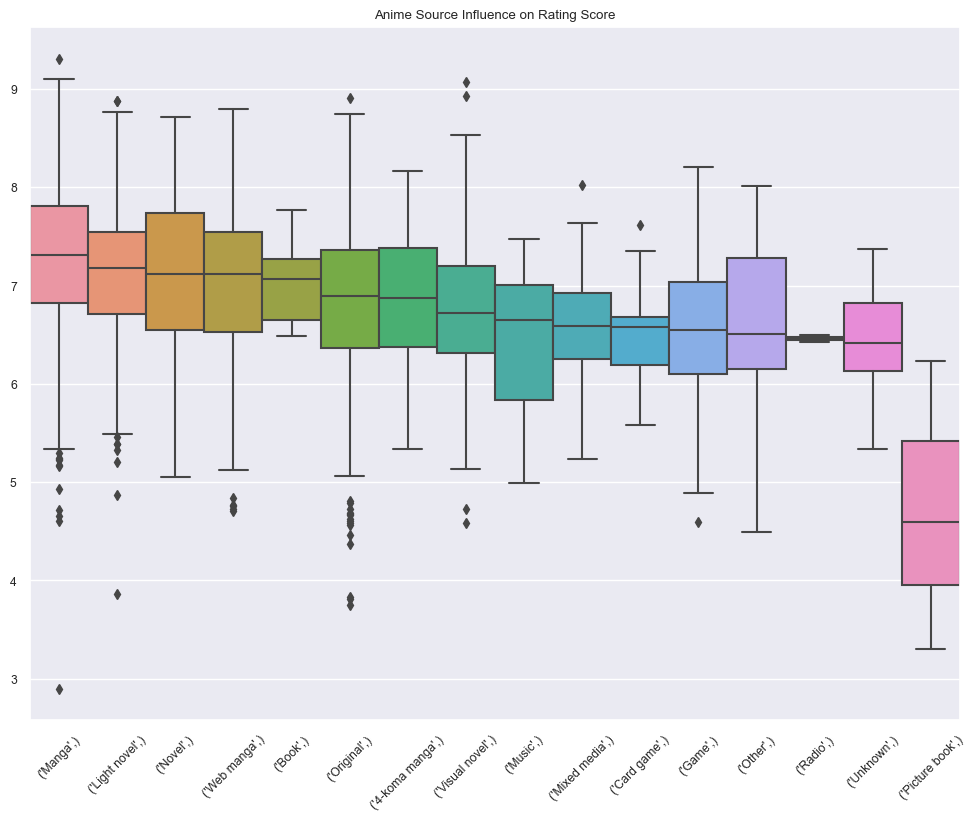

In [4]:
#Group for Source predictor and sort by median
grouped = main_df.groupby(['Source'])
grouped_df = pd.DataFrame({col:vals['Score'] for col, vals in grouped})
meds = grouped_df.median()
meds.sort_values(ascending = False, inplace = True)
sorted_df = grouped_df[meds.index]

#Create and customize boxplot
sns.set_theme(rc={'figure.figsize':(12, 9)}, font_scale = 0.8)
plt.xticks(rotation=45)
sns.boxplot(data = sorted_df, width = 1).set_title('Anime Source Influence on Rating Score')

This boxplot analyzes the relationship between anime sources and their respective review scores. The anime data set is loaded from a CSV file into a Pandas Dataframe then categorized by their origin (manga, light novels, original works) in the source column. Each boxplot generated with Seaborn and Matplotlib represents a different source for anime and includes the median score for each source indicated by the central line in the box, interquartile range (IQR) which shows the middle 50% of the data, and whiskers which shows signs of more variation in animes based on visual novels than others, with some outliers. Web Novels and Manga have higher median scores while Music and Picture Books have lower median scores with more variability.  The boxplot graph also checks for multicollinearity among predictors using the variance inflation factor (VIF) analysis which converts dummy variables for categorical source columns into numbers to do regression analysis and drops the first category in each column. With the information from the boxplot graph, it is possible to carefully infer that a pre-existing fanbase for popular anime sources (manga, light novels) may positively influence scores due to bias, although further analysis is necessary due to the presence of outliers in virtually every category which may suggest that some may perform poorly regardless of source due to other factors that may include execution differences. Further investigation may be necessary to investigate how adaptation quality and execution could be another factor in anime ratings.

Text(0.5, 1.0, 'Anime Studio Influence on Rating Score (top 10)')

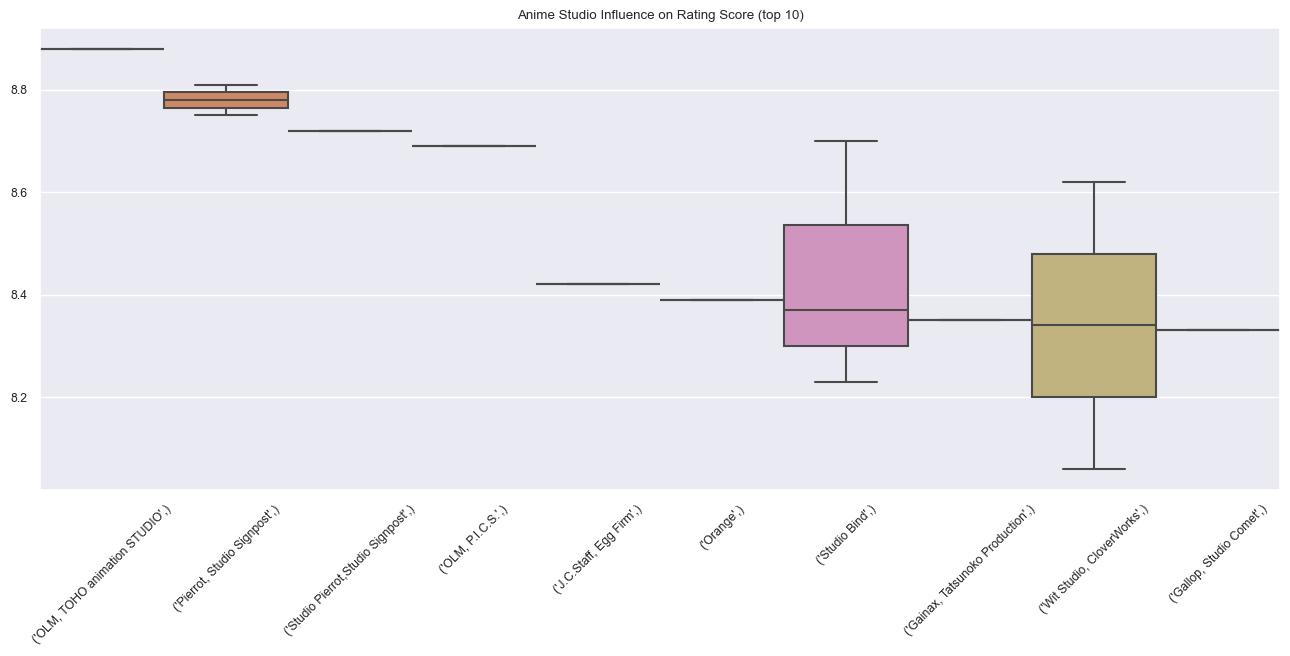

In [ ]:
#Group for Genre predictor and sort by median
grouped = main_df.groupby(['Studios'])
grouped_df = pd.DataFrame({col:vals['Score'] for col, vals in grouped})
meds = grouped_df.median()
meds.sort_values(ascending = False, inplace = True)
sorted_df = grouped_df[meds.index]

#Sort for top 10
studio_top = sorted_df.iloc[:,:10]

#Create and customize boxplot
sns.set_theme(rc={'figure.figsize':(16, 6)}, font_scale = 0.8)
plt.xticks(rotation=45)
sns.boxplot(data = studio_top, width = 1).set_title('Anime Studio Influence on Rating Score (top 10)')

Text(0.5, 1.0, 'Anime Studio Influence on Rating Score (Bottom 10)')

C:\Users\tonyb\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 12539 (\N{KATAKANA MIDDLE DOT}) missing from current font.
  func(*args, **kwargs)
C:\Users\tonyb\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12539 (\N{KATAKANA MIDDLE DOT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


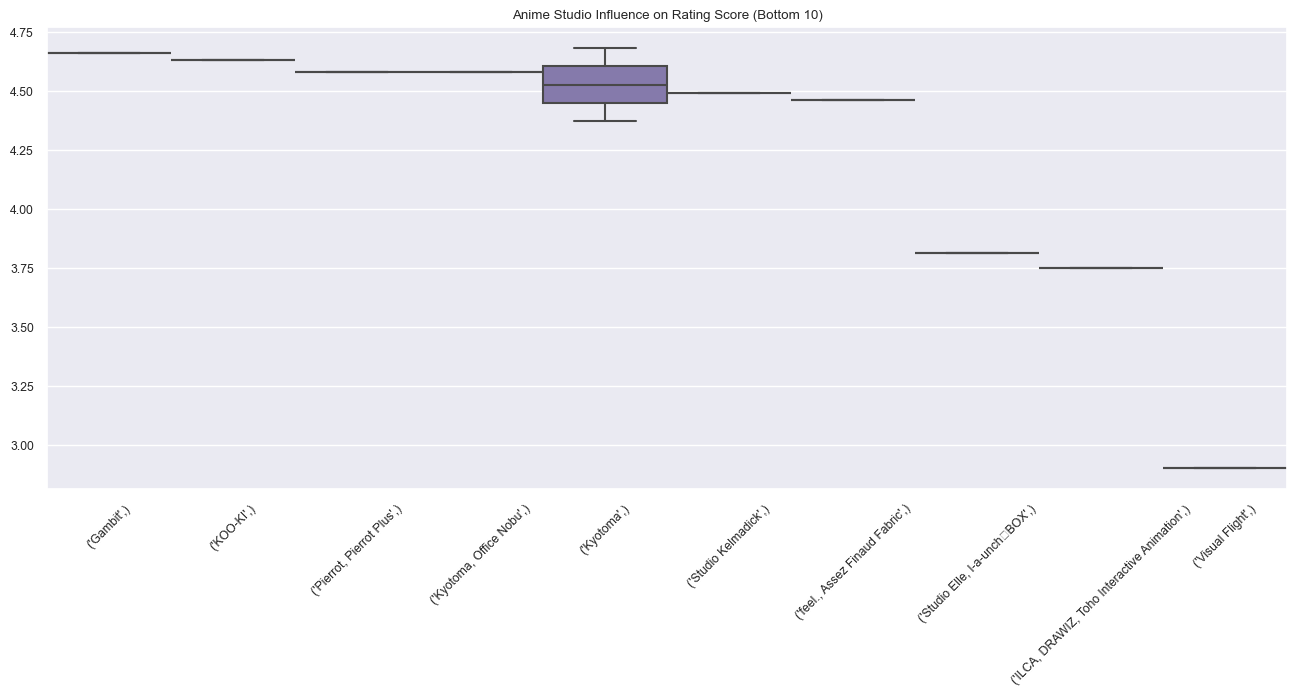

In [ ]:
#Sort for bottom 10
studio_bot = sorted_df.iloc[:,-10:]

#Create and customize boxplot
sns.set_theme(rc={'figure.figsize':(16, 6)}, font_scale = 0.8)
plt.xticks(rotation=45)
sns.boxplot(data = studio_bot, width = 1).set_title('Anime Studio Influence on Rating Score (Bottom 10)')

Text(0.5, 1.0, 'Anime Licensor Influence on Rating Score (top 10)')

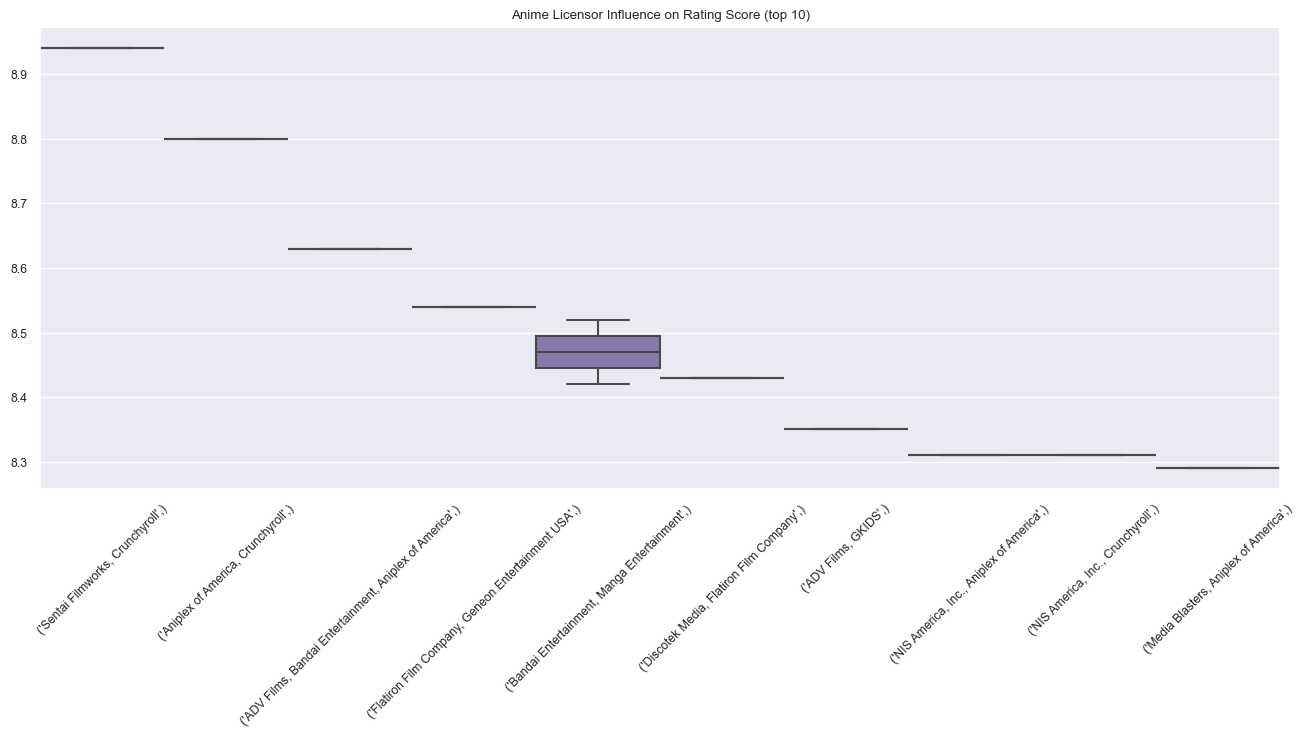

In [ ]:
#Group for Genre predictor and sort by median
grouped = main_df.groupby(['Licensors'])
grouped_df = pd.DataFrame({col:vals['Score'] for col, vals in grouped})
meds = grouped_df.median()
meds.sort_values(ascending = False, inplace = True)
sorted_df = grouped_df[meds.index]


#Sort for top 10
lisc_top = sorted_df.iloc[:,:10]

#Create and customize boxplot
sns.set_theme(rc={'figure.figsize':(16, 6)}, font_scale = 0.8)
plt.xticks(rotation=45)
sns.boxplot(data = lisc_top, width = 1).set_title('Anime Licensor Influence on Rating Score (top 10)')

Text(0.5, 1.0, 'Anime Licensor Influence on Rating Score (Bottom 10)')

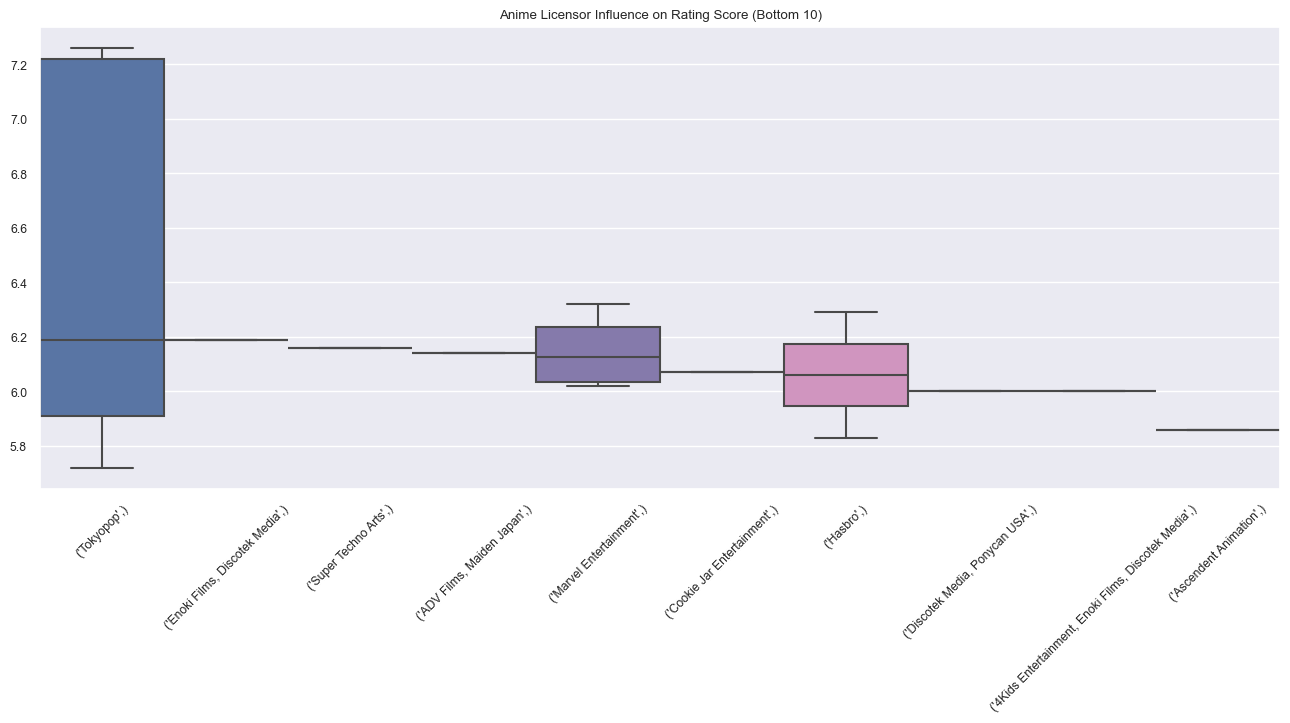

In [ ]:
#Sort for bottom 10
lisc_bot = sorted_df.iloc[:,-10:]

#Create and customize boxplot
sns.set_theme(rc={'figure.figsize':(16, 6)}, font_scale = 0.8)
plt.xticks(rotation=45)
sns.boxplot(data = lisc_bot, width = 1).set_title('Anime Licensor Influence on Rating Score (Bottom 10)')

Text(0.5, 1.0, 'Anime Genre Influence on Rating Score (top 10)')

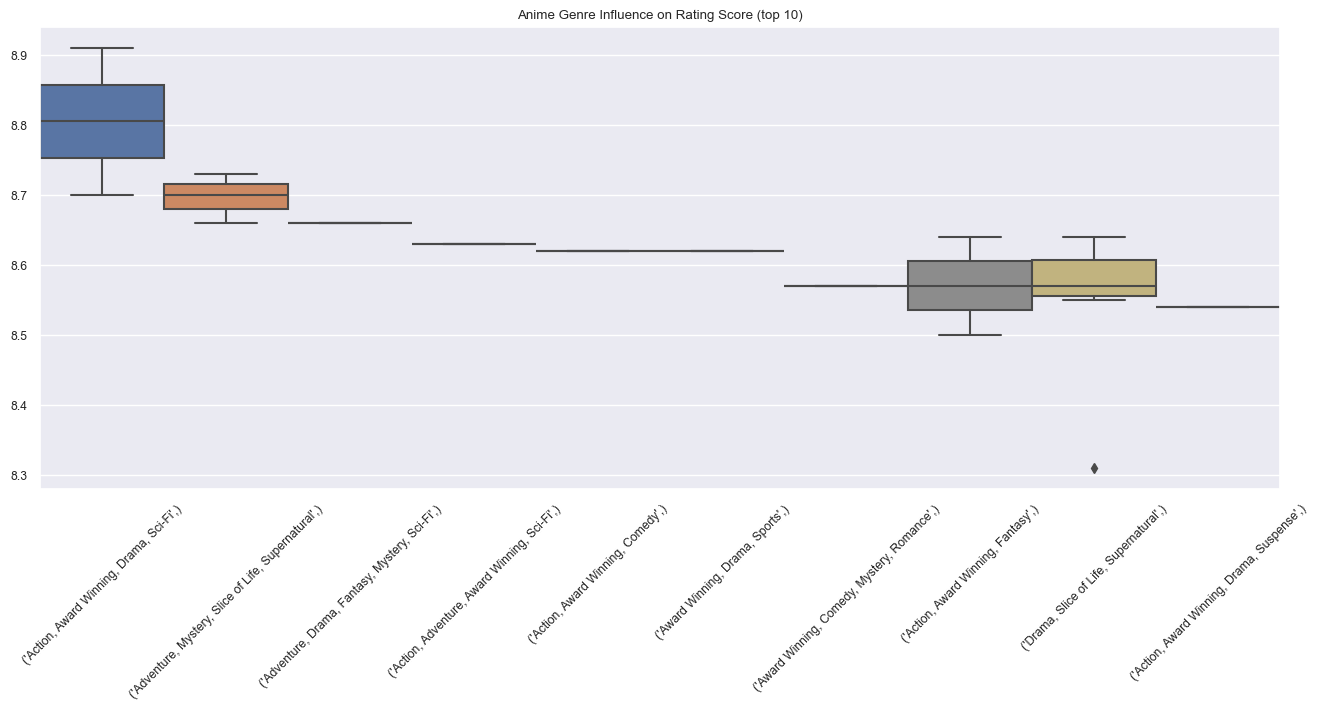

In [ ]:

#Group for Genre predictor and sort by median
grouped = main_df.groupby(['Genres'])
grouped_df = pd.DataFrame({col:vals['Score'] for col, vals in grouped})
meds = grouped_df.median()
meds.sort_values(ascending = False, inplace = True)
sorted_df = grouped_df[meds.index]

#Sort for top 10
genres_top = sorted_df.iloc[:,:10].dropna(axis=1, how = 'all')

#Create and customize boxplot
sns.set_theme(rc={'figure.figsize':(16, 6)}, font_scale = 0.8)
plt.xticks(rotation=45)
sns.boxplot(data = genres_top, width = 1).set_title('Anime Genre Influence on Rating Score (top 10)')


Text(0.5, 1.0, 'Anime Genre Influence on Rating Score (Bottom 10)')

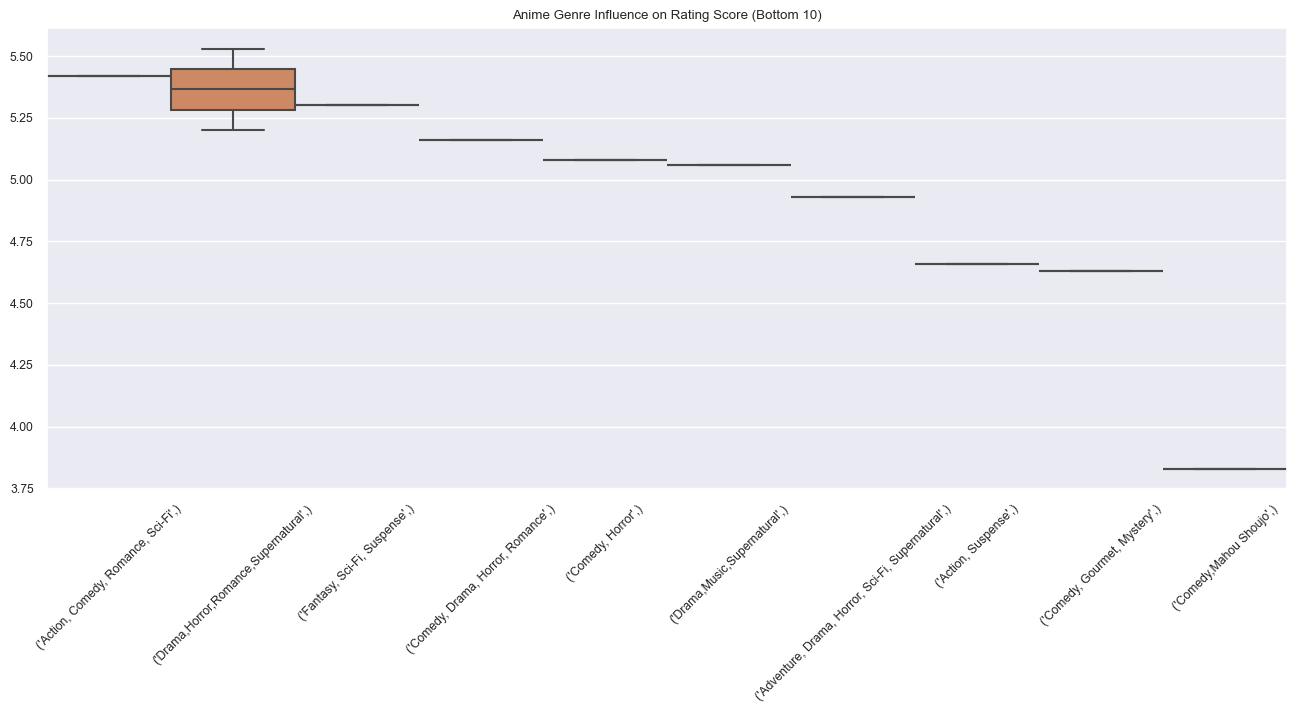

In [ ]:
#Sort for bottom 10
genres_bot = sorted_df.iloc[:,-10:].dropna(axis=1, how = 'all')

#Create and customize boxplot
sns.set_theme(rc={'figure.figsize':(16, 6)}, font_scale = 0.8)
plt.xticks(rotation=45)
sns.boxplot(data = genres_bot, width = 1).set_title('Anime Genre Influence on Rating Score (Bottom 10)')

In [ ]:
def separateGenres(df :pd.DataFrame):
    returnList = []
    for row in df.itertuples(index=False):
        genres = row.Genres.split(',')
        for genre in genres:
            row_list = list(row)
            row_list.append(genre.strip())
            returnList.extend([row_list])
    
    return pd.DataFrame(returnList, columns=['anime_id','Name','Score','Genres','Episodes','Studios','Licensors','Source', 'main_genre'])

Text(0.5, 1.0, 'Anime Genre Influence on Rating Score')

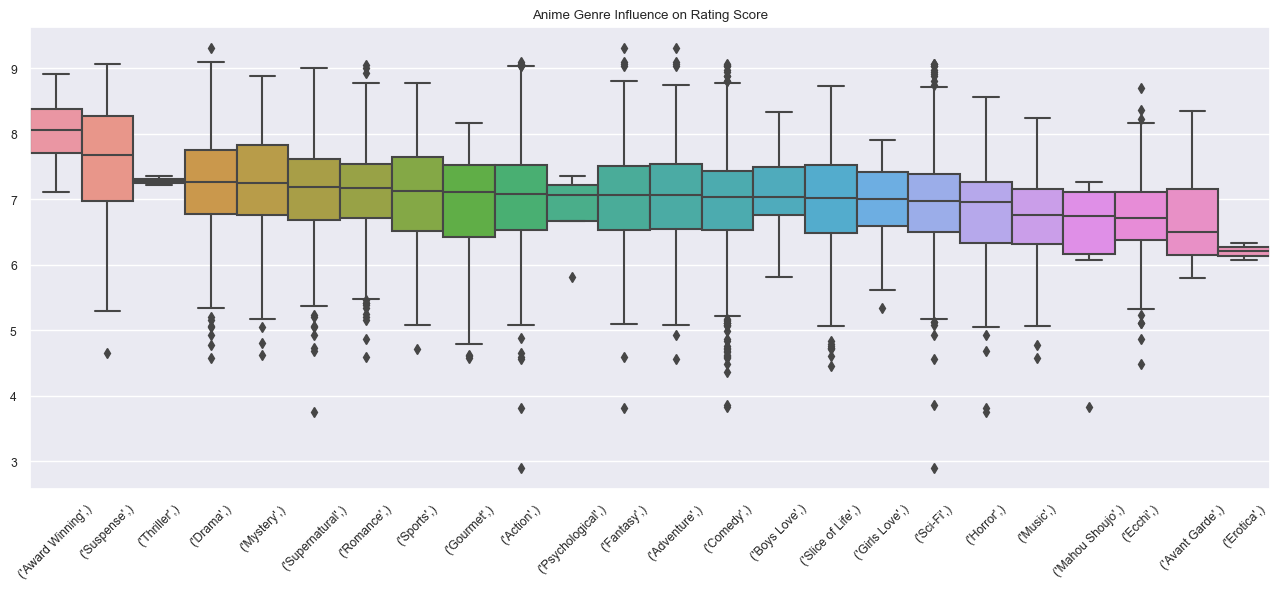

In [ ]:
dfSeparateGenres = separateGenres(main_df)
grouped = dfSeparateGenres.groupby(['main_genre'])
grouped_df = pd.DataFrame({col:vals['Score'] for col, vals in grouped})
meds = grouped_df.median()
meds.sort_values(ascending = False, inplace = True)
sorted_df = grouped_df[meds.index]

sns.set_theme(rc={'figure.figsize':(16, 6)}, font_scale = 0.8)
plt.xticks(rotation=45)
sns.boxplot(data = sorted_df, width = 1).set_title('Anime Genre Influence on Rating Score')

Text(0.5, 0.98, 'Anime Episodes Influence on Rating Score')

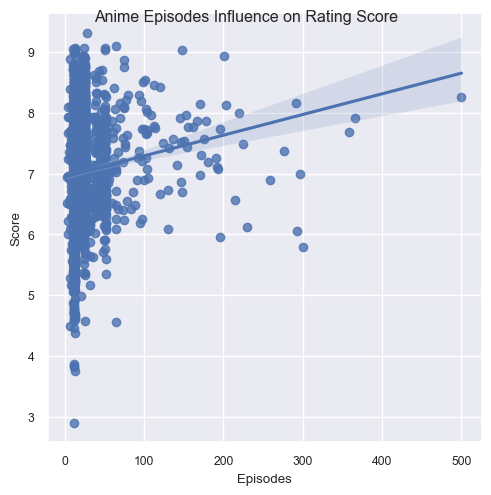

In [ ]:
#Create episodes scatterplot with regression line
ep_plot = sns.lmplot(data = main_df, x = 'Episodes', y = 'Score')
fig = ep_plot.fig
fig.suptitle('Anime Episodes Influence on Rating Score')

Text(0.5, 0.98, 'Anime Episodes Influence on Rating Score (For < 300 Episodes)')

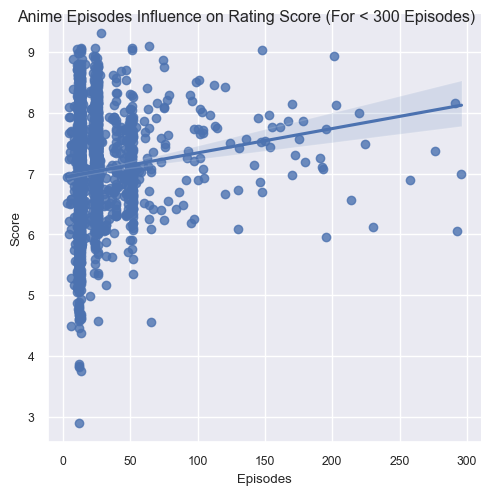

In [ ]:
#Zoom the graph in to shows with less than 300 episodes
ep_plot2 = sns.lmplot(data = main_df[main_df['Episodes'] < 300], x = 'Episodes', y = 'Score')
fig = ep_plot2.fig
fig.suptitle('Anime Episodes Influence on Rating Score (For < 300 Episodes)')

### Prediction

Finally, let's model our dataset using linear regression to try and see if it is possible to predict the score of an anime

In [8]:
import statsmodels.formula.api as smf

model = smf.ols(formula='Score ~ C(Genres) + Episodes + C(Studios) + C(Licensors) + C(Source)', data=main_df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     3.613
Date:                Mon, 17 Mar 2025   Prob (F-statistic):          4.90e-135
Time:                        11:53:34   Log-Likelihood:                -1842.8
No. Observations:                3032   AIC:                             5962.
Df Residuals:                    1894   BIC:                         1.281e+04
Df Model:                        1137                                         
Covariance Type:            nonrobust                                         
                                                                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

Looking at the p-values for this linear regression model, a vast majority of the categories have a p-value above 0.05, meaning the assigned coefficient could be attributed to random chance and not a good variable to be used for predicting score. In addition, the model tells us that there might be strong multicolinearity between the features, so we will use a variance inflation factor function to check for multicolinearity

In [5]:
##VIF/MULTICOLLINEARITY CALCULATION
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Create dummies and have independent variables in one dataframe
df_dummies = pd.get_dummies(main_df[['Genres', 'Episodes', 'Studios', 'Licensors', 'Source']], 
                            columns=['Genres', 'Episodes', 'Studios', 'Licensors', 'Source'], 
                            dtype = float, drop_first = True)

#Create vif dataframe and calculate
vif_df = pd.DataFrame()
vif_df['features'] = df_dummies.columns

vif_df['VIF'] =  [variance_inflation_factor(df_dummies.values, i)
                          for i in range(len(df_dummies.columns))]
vif_df


c:\Users\tonyb\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,features,VIF
0,"Genres_Action, Adventure",2.421484
1,"Genres_Action, Adventure, Award Winning, Comed...",1.841832
2,"Genres_Action, Adventure, Award Winning, Drama...",1.815949
3,"Genres_Action, Adventure, Award Winning, Drama...",1.147945
4,"Genres_Action, Adventure, Award Winning, Drama...",inf
...,...,...
1314,Source_Picture book,1.325014
1315,Source_Radio,1.418244
1316,Source_Unknown,3.614044
1317,Source_Visual novel,4.392300


If the VIF of a feature is above a 5, it indicates that there is some correlation. If the VIF of a feature is infinite, it indicates perfect correlation, so we will filter VIF for VIF score above a 5 or VIF equal to 'inf'

In [15]:
vif_df[(vif_df.get('VIF') > 5) | (vif_df.get('VIF') == 'inf')]

,features,VIF
4,"Genres_Action, Adventure, Award Winning, Drama...",inf
5,"Genres_Action, Adventure, Award Winning, Sci-Fi",inf
9,"Genres_Action, Adventure, Comedy, Drama, Horro...",inf
16,"Genres_Action, Adventure, Comedy, Fantasy, Gou...",inf
24,"Genres_Action, Adventure, Comedy, Romance",inf
63,"Genres_Action, Avant Garde, Award Winning, Dra...",inf
66,"Genres_Action, Award Winning, Drama, Romance, ...",inf
92,"Genres_Action, Comedy, Fantasy, Supernatural",inf
96,"Genres_Action, Comedy, Horror, Mystery, Supern...",inf
98,"Genres_Action, Comedy, Horror, Supernatural, S...",inf


Let's go through these variables with high multicolinearity feature by feature
- Genres - all of the genres with a VIF of 'inf' correlates with a single anime in the dataset, so it makes sense that it would have strong multicolinearity with other features since there's only one entry to go off of. For the 3 genres with a VIF above 5, they have multiple animes with the same genre except Adventure, Drama, Fantasy, Romance where it only has one entry
- Episodes - all the episode counts with a VIF of 'inf' again only correlate with a single anime. For the 3 episode counts with the 3 highest VIFs, 12, 13, and 26, it makes sense that these have a high VIF value because 90% of the animes being produced have either 12 episodes or 24/26 episodes, which forces a strong multicolinearity with other features
- Studios - again, the studios variables with a VIF of 'inf' correlates with only 1 anime. For the studios that have a VIF above 5, they have many animes with episode counts of around either 12 or 24, which matches up with the previous bullet point, but they also have many repeating licensors
- Licensors - the licensors that have a VIF above 5 are the streaming platforms that people use the most, with Crunchyroll being the most popular and the one with the highest VIF. It makes sense that the licensors with a VIF above 5 are correlated with other features because of their popularity
- Source - the source material for the majority of the animes produced are either adapted from manga, light novel, or are original works, so the source feature will invariably be correlated with the other features. In addition, the 4 sources that have the highest amounts in this dataset are manga (1124 animes), original (637 animes), light novel (423 animes), and game (195 animes)

# Ethics & Privacy

We got our data from Kaggle, which ranks the animes off of MyAnimeList.com. There is privacy between the data because we are going through the anonymous opinions of viewers on show popularity. However, there is potential bias because the genres of anime can depend on the viewer.
For instance, if the most common shows are shonen, then there could be higher-rated animes on MyAnimeList that belong to different genres, hence underrepresenting other types of anime.
One way to detect these biases throughout the project is by making sure the data we collect isn’t invasive to any personal information of anybody.
One problem that can affect our data analysis is that the ratings might be skewed towards popular genres, which impacts the fairness of rankings. To handle this issue, we can analyze the distribution of genres in the dataset to check for any disproportion.
1. We should Calculate the distribution of anime genres in the dataset. We can do this by visualizing the distribution through bar charts, and compare the genres.
2. Rate the analysis by Genre. Segment the data by genre, and compute the average ratings for each. By doingso, we can identify any genres with significantly higher or lower ratings, which could be overrepresented.
3. Check if there is a correlation between popularity and ratings. This can be done by examining the relationship between the two, and checking if highly popular anime genres have higher ratings.
4. Ensure the sample of anime included in the dataset is representative of the full range of genres. If certain genres are underrepresented, consider stratified sampling methods to balance the dataset.
5. Check for Bias through statistical testing to check for significant differences in ratings across genres.
6. Mitigate any Bias through weighing ratings by genre representation to balance their impact. Alternatively, we could separate rankings for each genre to avoid cross-genre comparison bias.
7. Clearly document any biases detected and the steps taken to address them. Ensure transparency by explaining how the data was sourced and any limitations it might have.

# Discusison and Conclusion

Wrap it all up here.  Somewhere between 3 and 10 paragraphs roughly.  A good time to refer back to your Background section and review how this work extended the previous stuff. 


# Team Contributions

Speficy who did what.  This should be pretty granular, perhaps bullet points, no more than a few sentences per person.